# Importing Libraries

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pdflatex
import pylatexenc
import gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Function
import random
from collections import deque
import importlib
import os

import train
importlib.reload(train)
from train import train_DQN
from train import train_quantum_dqn

from qiskit import *
from qiskit import QuantumCircuit
from qiskit import transpile
from qiskit.circuit import Parameter
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_aer import Aer
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.quantum_info import Pauli
from qiskit.quantum_info import SparsePauliOp


# Quick Check to see if my GPU is being detected
#device = torch.device("cuda" if torch.cuda.is_available() else  "cpu")
device = torch.device("cpu")
print("Using ", device)
print(gym.__version__)


ModuleNotFoundError: No module named 'torch'

# Classes used for Modelling

- Setup the Classical Deep-Q-Network

- Setup a Hybrid DQN that utilises the same structure as the above classical network, but with a 4-qubit VQC at the start.

- The Hybrid DQN has two variations based on estimator and sampler QNNs.

In [2]:

# A class deescribing a simple DQN
class Classical_DQN(nn.Module):
    def __init__ (self, state_size, action_size):
        super(Classical_DQN,self).__init__()

        self.layer_1 = nn.Linear(state_size, 256)
        self.layer_2 = nn.Linear(256,256)
        self.output  = nn.Linear(256, action_size)

    def forward(self, x):
        x = nn.functional.relu(self.layer_1(x))
        x = nn.functional.relu(self.layer_2(x))
        return self.output(x)
    

    


    
# A class describing a hybrid quantum-classical dqn
class Hybrid_DQN(nn.Module):
    
    def __init__(self, state_size, action_size):
        super(Hybrid_DQN,self).__init__()

        self.state_size = state_size
        self.action_size = action_size
        self.num_qubits = 4
        self.quantum_layer     = self.create_quantum_layer_type1()
        self.classical_layer_1 = nn.Linear(4, 256)
        self.classical_layer_2 = nn.Linear(256, 256)
        self.output_layer      = nn.Linear(256, action_size)


    # Angle encoding for the cartpole state variables
    def encode_cartpole_state(self, x):
        
        min_vals = torch.tensor([-4.8, -3.0, -0.418, -3.0]) # The reasonable minimum values of the state variables
        max_vals = torch.tensor([4.8, 3.0, 0.418, 3.0]) # The reasonable maximum values of the state variables

        theta_vals = (x - min_vals) / (max_vals - min_vals) * (2 * torch.pi) - torch.pi
        return theta_vals
    




    def forward(self, x):

        x = x.to(next(self.parameters()))
        theta_vals = self.encode_cartpole_state(x) # Determine encoding parameter values

        quantum_output = self.quantum_layer(theta_vals) # Encode the state variables in a quantum format

        x = torch.relu(self.classical_layer_1(quantum_output))
        x = torch.relu(self.classical_layer_2(x))
        return self.output_layer(x)
    



    def create_quantum_layer_type1(self):

        num_qubits = 4
        vqc = QuantumCircuit(num_qubits)

        # To transalte the state vector into a quantum representation
        encoding_params = [Parameter(f'theta_{i}') for i in range(num_qubits)]
        trainable_params = [Parameter(f'w_{i}') for i in range(num_qubits)]

        # Encoding
        for i, param in enumerate(encoding_params):
            vqc.ry(param, i)

        # Hadamard each qubit
        for i in range(num_qubits):
            vqc.h(i)

        for i in range(3):
            vqc.cx(i, i + 1)
        vqc.cx(3, 0)

        # The Actual VQC
        for i, param in enumerate(trainable_params):
            vqc.ry(param, i)


        # An observable for each Z-value of each qubit. Effectively telling us what the qubits expectation is in terms of  |0> and |1>
        observables = [
        SparsePauliOp.from_list([("ZIII", 1)]),
        SparsePauliOp.from_list([("IZII", 1)]),
        SparsePauliOp.from_list([("IIZI", 1)]),
        SparsePauliOp.from_list([("IIIZ", 1)])
        ]

        qnn = EstimatorQNN(
            circuit=vqc,
            input_params =encoding_params,
            weight_params=trainable_params,
            observables  = observables
                    )
        return TorchConnector(qnn)
    


class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)  # FIFO queue to hold experiences

    # Add an experience to the buffer
    def add(self, state, action, reward, next_state, done):
        
        self.buffer.append((state, action, reward, next_state, done))

    # Sample an experience from the buffer
    def sample(self, batch_size):

        return random.sample(self.buffer, batch_size)

    # Return the currenlength of the buffer
    def size(self):
        return len(self.buffer)
    



NameError: name 'nn' is not defined

# Environment Setup

In [11]:
env = gym.make("CartPole-v0")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n


# Creating live and target models
live_model = Classical_DQN(state_size, action_size).to(device)

target_model = Classical_DQN(state_size, action_size).to(device)
target_model.load_state_dict(live_model.state_dict())
target_model.eval()  

print(live_model, "\n")


live_qmodel = Hybrid_DQN(state_size, action_size)
print(hasattr(live_qmodel, 'encode_cartpole_state'))

target_qmodel = Hybrid_DQN(state_size, action_size)
target_qmodel.load_state_dict(live_qmodel.state_dict())
target_qmodel.eval()  

print(live_qmodel)


print("Environment and models are set up.")

Classical_DQN(
  (layer_1): Linear(in_features=4, out_features=256, bias=True)
  (layer_2): Linear(in_features=256, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=2, bias=True)
) 

True
Hybrid_DQN(
  (quantum_layer): TorchConnector()
  (classical_layer_1): Linear(in_features=4, out_features=256, bias=True)
  (classical_layer_2): Linear(in_features=256, out_features=256, bias=True)
  (output_layer): Linear(in_features=256, out_features=2, bias=True)
)
Environment and models are set up.


c:\Users\Saad\miniconda3\envs\QRL\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


# Hyperparameter Tuning 

- Exactly what it sounds like.

- Most parameters are taken from Evans work (Some of which he takes from other work)

In [6]:

# Create the training buffer for experience replay
buffer_capacity = 4000
replay_buffer = ReplayBuffer(buffer_capacity)


# Optimisers for the classical and quantum networks
optimizer = optim.Adam(live_model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

optimizerq = optim.Adam(live_qmodel.parameters(), lr=0.001)
criterionq = torch.nn.MSELoss()

gamma = 0.98              # Discount factor for future rewards (Not specified) 
epsilon = 1.0             # Initial exploration rate (Specified)
epsilon_decay = 0.99      # Decay rate for epsilon (Specfied)
epsilon_min = 0.005       # Minimum exploration rate (Specified) 
batch_size = 128          # Number of experiences sampled per update (Specified)
target_update_freq = 10   # Frequency to update the target network (Not specified)
num_episodes = 300        # The number of episodes or epochs to train (Specified)

# Model Training

- First cell is classical

- Second cell is hybrid

In [ ]:
# Train the model
y = train_DQN(env, epsilon, epsilon_decay, num_episodes, replay_buffer, batch_size, target_update_freq, epsilon_min, gamma, device, live_model, target_model, criterion, optimizer)

#y = [1,2,3,4]
filename = f"Training/output_{os.getpid()}.txt"
np.savetxt(filename, y, fmt='%f')

c:\Users\Saad\Project\train.py:123: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
c:\Users\Saad\miniconda3\envs\QRL\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


KeyboardInterrupt: 

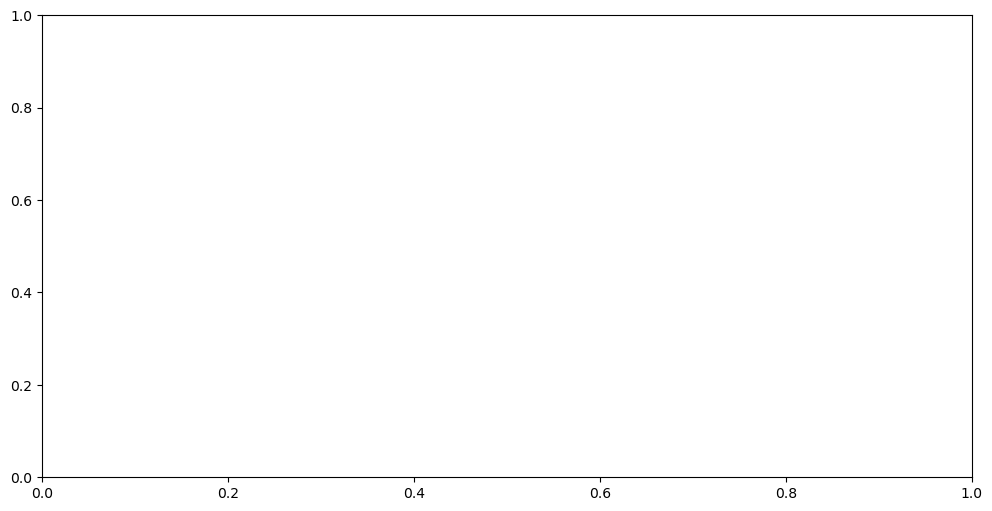

In [13]:
q = train_quantum_dqn(env, epsilon, epsilon_decay, num_episodes, replay_buffer, batch_size, target_update_freq, epsilon_min, gamma, device, live_qmodel, target_qmodel, criterion, optimizerq)

#x = live_qmodel(torch.tensor([0.1,0.2,0.3,0.4]))
filename = f"Training/Cyclic_{os.getpid()}.txt"

np.savetxt({filename}, q, fmt='%f')
